# Machine Learning for Textual Data - The Bible
<b> Advanced Numberical Methods and Data Analysis - University of St. Gallen (HSG) - Spring semester 2019 </b>

Elisa Fleissner       (14-350-608)

Lars Stauffenegger    (tbd)

Alexander Steeb       (tbd)

07.05.2019

--------------------------------------------------------------------------------------------

# Project plan

**TODO:**

In this project we analyse the bible text using machine learning for textual data. From this analysis we expect to see different relevant topics and contexts between the books of the bible.

In a first step, we need to setup helpers function and import all relevant libraries used for this project.
Then we are importing the data and assigning the correct names of the books to the texts as well as the testament (old or new). 
We then have to process the data to make it suitable for the machine learning algorithm. We achieve this by [...].
...

Etc.

Two models: Word count/frequency (LDA) and word2vec


In [37]:
import sys
print(sys.executable)
print(sys.version)

/anaconda3/bin/python
3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## 0. Setup

In [63]:
# import functions
import json
import os
import pandas as pd

import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
#from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Option to display whole text and not only first few words
pd.set_option('display.max_colwidth', -1)


SyntaxError: invalid syntax (<ipython-input-63-11d0211a34e7>, line 12)

In [39]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elisafleissner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
# Helper functions

# based on: https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty-with-python
import shutil
def remove_folder(path):
    # check if folder exists
    if os.path.exists(path):
         # remove if exists
         shutil.rmtree(path)
    else:
         # throw your exception to handle this special scenario
         raise ValueError('Folder already exists')

## 1. Data import

**TODO:**

Überlegen, ob wir noch einen zweiten text anschauen wollen und wenn ja suchen, wo es diesen online gibt

Code sollte soweit passen, kann nur vielleicht noch kommentiert werden

Source:
https://sites.google.com/site/ruwach/bibletext

In [41]:
import requests, zipfile, io

#remove_folder("data")


#old_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_OldTestament.zip?attredirects=0"

old_zip_file_url = "http://ruwach.googlepages.com/OldTestament.zip"

#new_zip_file_url = "https://sites.google.com/site/ruwach/Basic_English_NewTestament.zip?attredirects=0"
new_zip_file_url = "http://ruwach.googlepages.com/NewTestament.zip"
    
def unzip(url):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("data/")
    
unzip(old_zip_file_url)
unzip(new_zip_file_url)

In [42]:
path = "data"
df = pd.DataFrame()  


testaments = os.listdir(path)

for testament in testaments:
    testament_path = os.path.join(path,testament)
    books = os.listdir(testament_path)
    print(testament) #do we need this?
    
    for book in books:
        book_path = os.path.join(testament_path,book)
        files = os.listdir(book_path)    
            
        for file in files:
            file_path = os.path.join(book_path,file) 
            
            with open(file_path,"r", encoding="utf-8") as infile:
                text = infile.read()
                df = df.append([[text, testament, book, file, file_path]], ignore_index=True)
                
df.columns = ["text", "testament", "book", "file", "path"]



OldTestament
NewTestament


In [43]:
books = (
    "Genesis",
    "Exodus",
    "Leviticus",
    "Numbers",
    "Deuteronomy",
    "Joshua",
    "Judges",
    "Ruth",
    "1 Samuel",
    "2 Samuel",
    "1 Kings",
    "2 Kings",
    "1 Chronicles",
    "2 Chronicles",
    "Ezra",
    "Nehemiah",
    "Esther",
    "Job",
    "Psalms",
    "Proverbs",
    "Ecclesiastes",
    "Song of Solomon",
    "Isaiah",
    "Jeremiah",
    "Lamentations",
    "Ezekiel",
    "Daniel",
    "Hosea",
    "Joel",
    "Amos",
    "Obadiah",
    "Jonah",
    "Micah",
    "Nahum",
    "Habbakuk",
    "Zephaniah",
    "Haggai",
    "Zechariah",
    "Malachi",
    "Matthew",
    "Mark",
    "Luke",
    "John",
    "Acts",
    "Romans",
    "1 Corinthians",
    "2 Corinthians",
    "Galatians",
    "Ephesians",
    "Philippians",
    "Colossians",
    "1 Thessalonians",
    "2 Thessalonians",
    "1 Timothy",
    "2 Timothy",
    "Titus",
    "Philemon",
    "Hebrews",
    "James",
    "1-2 Peter",
    "1-3 John",
    "Jude",
    "Revalation")

In [44]:
books_order = pd.DataFrame.from_records(zip(books, range(1,len(books))))

books_order.columns = ["book", "order"]

df = pd.merge(df,books_order, on='book')

In [45]:
df = df.sort_values(["order","file"], ascending=[True,True])
df.reset_index(drop=True, inplace=True)

## 2. Data cleaning

**TODO**

Aktuell ist der code zu Teilen noch 1:1 aus dem Beispiel. Muss noch geändert werden bzw das Beispiel als Qulle / Inspiration angegeben werden


**TODO**

In this section we will prepare the data to be analysed. We therefore need to apply different techniques to clean the data so that machine learning algorithms can analyse the data set. For a first inspection of the data, we will use a wordcloud and word count analysis.

https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34 gives a good summary over the data pre-processing step, i.e. tokenizations and word stemming / lemmatization. 
Steps: 
1. Remove Blank rows in Data, if any
2. Change all the text to lower case
3. Word Tokenization
4. Remove Stop words
5. Remove Non-alpha text
6. Word Lemmatization (rather than stemming)


Data cleaning: Stemming, tokenization, see other documentation
Data visualisation (eg wordcloud)
Data inspection

In [46]:
# Step 1, 2 and 5
def preprocessor(text):
    '''removing all punctuation, non-letter characters and white spaces'''
    text.strip()
    text = (re.sub('[\W]+', ' ', text.lower()))      #remove non-word characters and make text lowercase
    text = (re.sub('[\d]+', '', text))               #to remove numbers [0-9]
    text = (re.sub('\n', ' ', text))

    return text.strip()

# Step 3
def tokenizer(text):
    '''split text into single words and return a list of these words'''
    return text.split()

# Step 4
def remove_stopwords(text):
    stop = stopwords.words('english')
    words = [word for word in text.split()]
    stopremoved = [w for w in words if w not in stop]
    return ' '.join(stopremoved)

# Step 6
# a) Stemming
def tokenizer_porter(text):
    '''Porter stemmer - split text and convert all words back to 
    their stem, e.g. running -> run, return a list of the stemmed words'''
    
    stop = stopwords.words('english')
    porter = PorterStemmer()
    
    stopremoved = [w for w in text.split() if w not in stop] #removing common stop words as downloaded from nltk package
    stem = [porter.stem(word) for word in stopremoved]

    return " ".join(stem)

# b) Lemmatization
def tokenizer_lemma(text):
    stop = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    
    stopremoved = [w for w in text.split() if w not in stop] #removing common stop words as downloaded from nltk package
    lemma = [lemmatizer.lemmatize(word) for word in stopremoved]

    return " ".join(lemma)

### Wordcloud

Available for old and new testament separated and the entire bible.

**TODO**

Kann eventuell auch noch etwas eleganter und hübscher gemacht werden

In [47]:
#apply preprocessor for Wordcloud and merge all preprocessed speeches to one text
wordcloud_df = df['text'].apply(preprocessor)
wordcloud_df = wordcloud_df.apply(remove_stopwords)

full_text = ''
for text in wordcloud_df:
    full_text += text
    
# generate word cloud 
wordcloud = WordCloud(max_font_size=40,background_color="white").generate(full_text)

# display
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

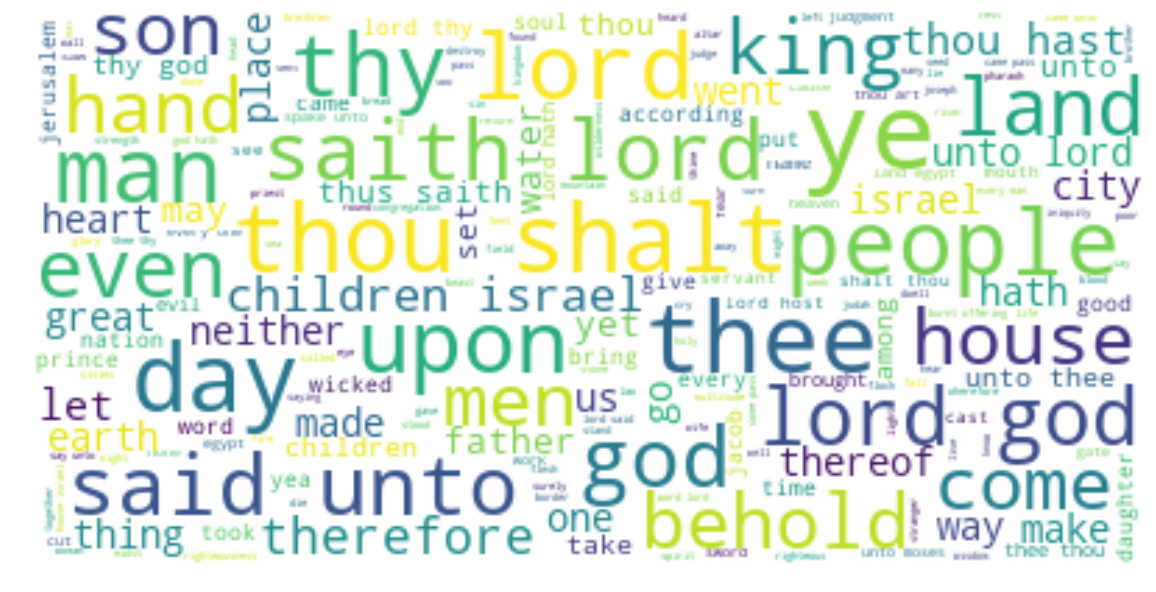

In [86]:
# Old testament only
wordcloud_old = df.loc[df.testament == "OldTestament",'text'].apply(preprocessor)
wordcloud_old = wordcloud_old.apply(remove_stopwords)

full_text = ''
for text in wordcloud_old:
    full_text += text

wordcloud_old = WordCloud(max_font_size=40,background_color="white").generate(full_text)

# display
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_old, interpolation="bilinear")
plt.axis("off")
plt.show()

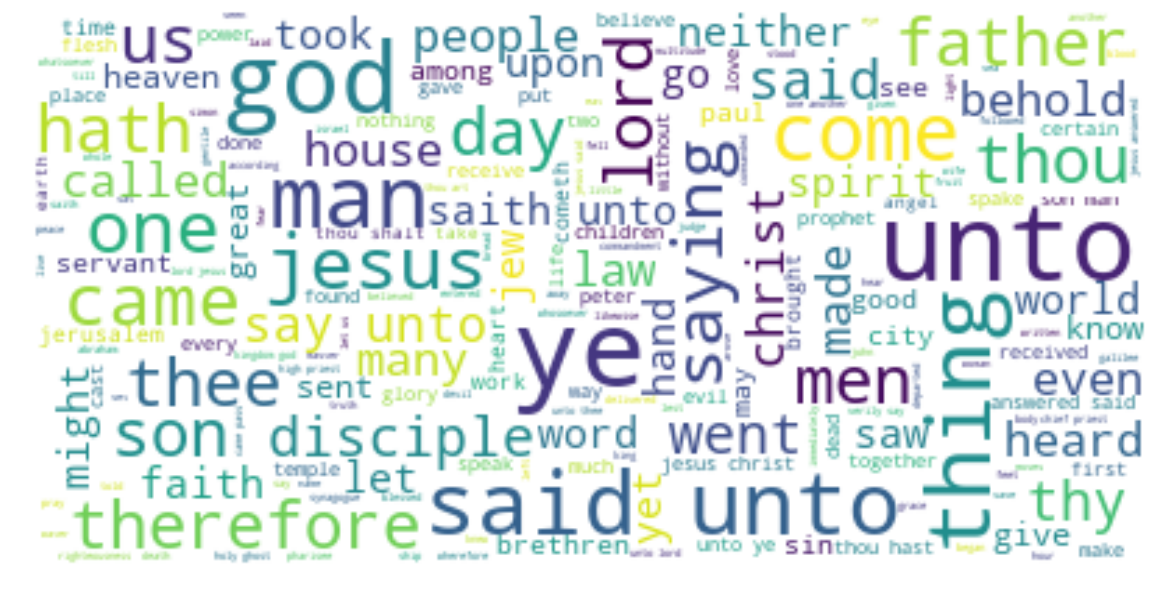

In [87]:
# New testament only
wordcloud_new = df.loc[df.testament == "NewTestament",'text'].apply(preprocessor)
wordcloud_new = wordcloud_new.apply(remove_stopwords)

full_text = ''
for text in wordcloud_new:
    full_text += text

wordcloud_new = WordCloud(max_font_size=40,background_color="white").generate(full_text)

# display
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_new, interpolation="bilinear")
plt.axis("off")
plt.show()

## Simple analysis

**TODO**

- Wieviele Wörter sind es insgesamt etc.
- Welche Wörter kommen am häufigsten vor im alten/ neune Testament etc.
- Plotten wo welche Wörter im Verlauf des gesamten Textes vorkommen

KeyboardInterrupt: 

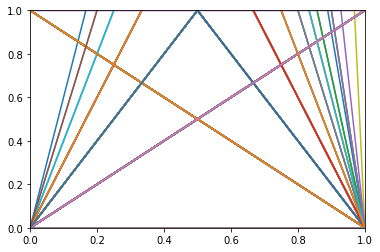

In [109]:
cv = CountVectorizer()
cv.fit(df['text'])
results = cv.transform(df['text'])
features = cv.get_feature_names()
df_res = pd.DataFrame(results.toarray(), columns=features)
df_res = df_res.sort_values()
plt.plot(df_res)

In [108]:
count_vectorizer = CountVectorizer()
word_counts = count_vectorizer.fit_transform(df["text"])
word_counts.vocabulary_

AttributeError: vocabulary_ not found

## 3. Model 1 - LDA

**TODO**

- Description of what is going on
- **Code abändern und kommentieren, damit er nicht 1:1 wie das beispiel ist**
- Können wir das preprocessing noch verbessern? (Die top wörter der topics enthalten teilweise noch Füllwörter)
- Können wir die Top Wörter der einzelnen Topics als Wordclouds darstellen? (Das könnte glaub ein cooles extra sein)
- Können wir unsere Daten noch mit irgendwas anreichern?

In [49]:
# Options:

n_components = 4

In [50]:
# apply preprocessor for LDA

# apply preprocessor to speeches in data frame
df['cleaned'] = df['text']
df['cleaned'] = df['cleaned'].apply(preprocessor)

#Processing documents into tokens (incl. stemming and removing stopwords)
df['cleaned'] = df['cleaned'].apply(tokenizer_porter)

In [51]:
#Transformation Into Feature Vectors that count how often words appear in different speeches
count = CountVectorizer(
            max_df=0.9,
            min_df=2,
            max_features=100_000,
            ngram_range=(1,2)
            )

#for testament in testaments:
#    text = df.loc[df['testament'] == testament,"cleaned"]
text = df.loc[:,"cleaned"]
X = count.fit_transform(text)  #sparse matrix

#fit LDA 
lda = LatentDirichletAllocation(n_components=n_components, random_state=1000, learning_method='batch')

nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)


X_topics = lda.fit_transform(X)
#X_topics = nmf.fit_transform(X)

lda.components_.shape
#print 5 most important words of every topic
print(testament)
print("The ten most important words of four topics are:")
print()
n_top_words = 10
feature_names = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))
print()
print()

NewTestament
The five most important words of three topics are:

Topic 1:
ye said shall god man say thou jesu thing said unto
Topic 2:
shall lord thi thou thee god upon hath saith ye
Topic 3:
shall offer lord son children one priest upon day israel
Topic 4:
lord thou thi thee god shall said land king ye




In [52]:
#for topic 1 to 5
print('Presidents in order of gving most weight to the specific topics')

titles = ['1', '2', '3',"4","5"]

for no in range(n_components):
    topic = X_topics[:, no].argsort()[::-1]  #sort in descending order and return index 
    print()
    print("Topic", str(no))
    print('-'*40)
    presi = []
    for speech in topic:
        presi.append(df['book'][speech])
        if len(set(presi)) == 3: #make sure we only pick the 3 top presidents who belong in topic the most
            break 
            
    #Keep order in list but remove duplicates
    output = []
    seen = set()
    for p in presi:
        # If value has not been encountered yet, add it to both list and set.
        if p not in seen:
            output.append(p)
            seen.add(p)

    for p in output:
        print(p)

Presidents in order of gving most weight to the specific topics

Topic 0
----------------------------------------
Matthew
Mark
Luke

Topic 1
----------------------------------------
Daniel
Jeremiah
Ezekiel

Topic 2
----------------------------------------
Numbers
Leviticus
Exodus

Topic 3
----------------------------------------
Deuteronomy
Genesis
Judges


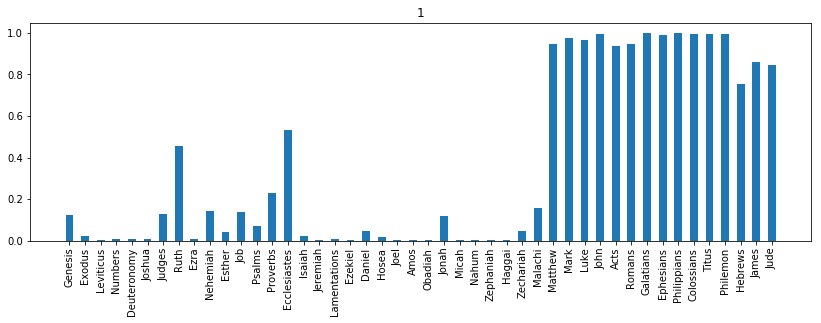

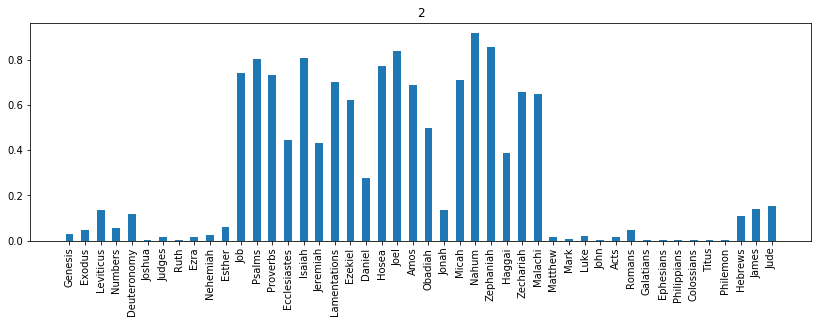

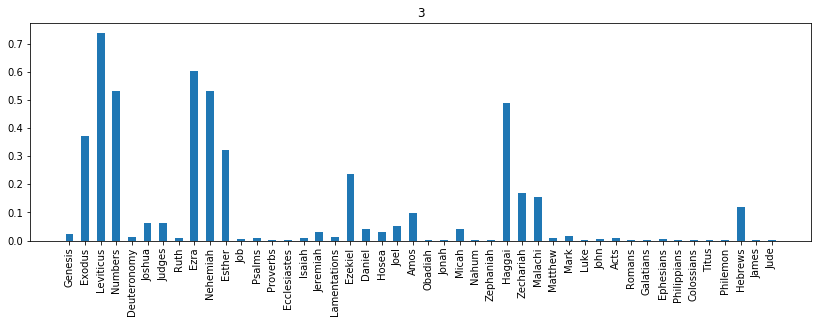

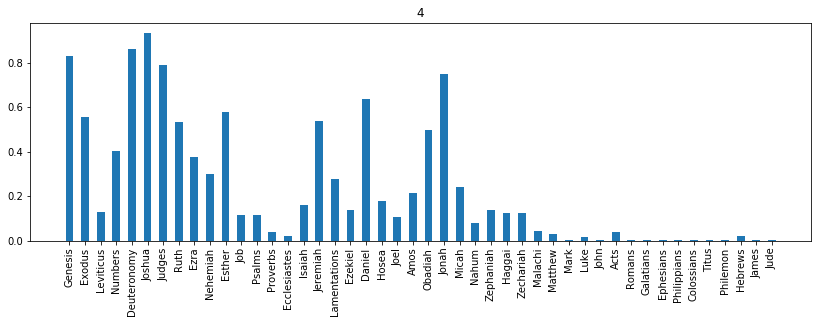

In [53]:
pset = set()  #set of all presidents
plist = []
for p in df['book']:
    if p not in pset:
        plist.append(p)
        pset.add(p)

weights=[]  #take the average over all speeches per president
for p in plist:
    line=[]
    indices = df.index[df['book'] == p]
    for i in indices:
        line.append(list(X_topics[i]))
    weights.append(list(np.mean(line, axis=0)))

#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 

#Plot for every single topic

for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    fig = plt.figure(figsize=(14,4))
    plt.bar(ind, t, width=width)
    plt.xticks(rotation=90)
    plt.xticks(ind , plist)
    plt.title(titles[x])

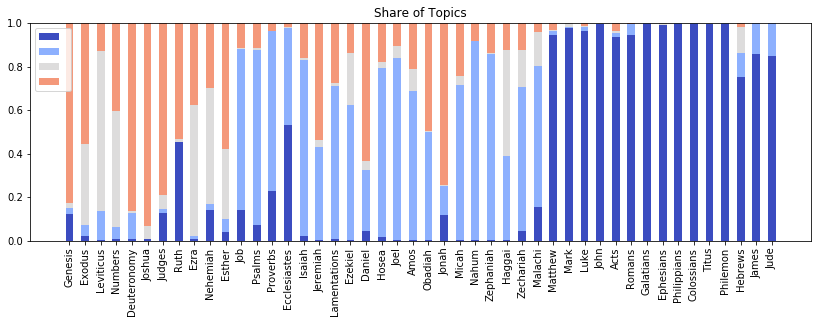

In [54]:
# #Stacked Bar plot
#prepare plot - inspiration and code examples from https://de.dariah.eu/tatom/topic_model_visualization.html
N, K = len(weights), len(weights[0])
ind = np.arange(N)
width = 0.5 
plots = []
height_cumulative = np.zeros(N)

s = []
for x in range(K):
    t = [] # alist with values for all 42 presidents for topic 1
    for entry in weights:
        t.append(entry[x])
    s.append(t)  #a list with 5 list, each with the weights on the respective topic per president
    
fig = plt.figure(figsize=(14,4))
for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, s[k], width, color=color)
    else:
        p = plt.bar(ind, s[k], width, bottom=height_cumulative, color=color)
    height_cumulative += s[k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.title('Share of Topics')
plt.xticks(rotation=90)
plt.xticks(ind , plist)
  
for i in range(len(titles)):
    titles[i] = titles[i][15:]

plt.legend(titles,loc=2)
print()

## 4. Model 2 - Word2vec

**TODO**

- Mehr insights erstellen (siehe link)
- z.B. was wird mit Gott im alten vs neune Testament verbunden etc. / Gott steht zu Jesus im Verhältnis wie ....
- Visualization of results

Source:
https://nbviewer.jupyter.org/github/danielfrg/word2vec/blob/master/examples/word2vec.ipynb

In [89]:
import word2vec

In [91]:
#remove_folder("model")
os.mkdir("model")

In [92]:
print(testaments[0])
with open("model/text_old.txt", "w") as text_file:
    text_file.write(str(df.loc[df['testament'] == testaments[0],'cleaned'].values))

print(testaments[1])
with open("model/text_new.txt", "w") as text_file:
    text_file.write(str(df.loc[df['testament'] == testaments[1],'cleaned'].values))

OldTestament
NewTestament


In [93]:
def estimate_word2vec(file):
    word2vec.word2phrase(train = file, 
                     output="model/text-phrases", 
                     min_count=1,
                     verbose=True)
    word2vec.word2vec("model/text-phrases", "model/text.bin", 
                  size=50, 
                  min_count=1,
#                  sample=1e-5, # Downsample high frequenzy words
                  verbose=True)
    return(word2vec.load('model/text.bin'))

In [94]:
## Predictions

In [95]:
print("Fit old testament model")
model_old = estimate_word2vec('model/text_old.txt')
print()
print("Fit new testament model")
model_new = estimate_word2vec('model/text_new.txt')

Fit old testament model
Starting training using file model/text_old.txt
Words processed: 200K     Vocab size: 106K  
Vocab size (unigrams + bigrams): 117809
Words in train file: 227663
Starting training using file model/text-phrases
Vocab size: 10064
Words in train file: 214680
Alpha: 0.002056  Progress: 92.72%  Words/thread/sec: 291.76k  
Fit new testament model
Starting training using file model/text_new.txt

Vocab size (unigrams + bigrams): 44036
Words in train file: 63730
Starting training using file model/text-phrases
Vocab size: 4784
Words in train file: 60564


In [98]:
indexes, metrics = model_old.similar("god")
model_old.generate_response(indexes, metrics).tolist()

[('therefor', 0.9778495927070284),
 ('bless', 0.9743107769878787),
 ('fear', 0.9674592572214651),
 ('prais', 0.9657553825359902),
 ('coven', 0.9630004832374642),
 ('done', 0.9624776552896139),
 ('keep', 0.9621863547205326),
 ('lord', 0.9616302321294123),
 ('statut', 0.9580708774738727),
 ('beseech', 0.9579918132042546)]

In [99]:
indexes, metrics = model_new.similar("god")
model_new.generate_response(indexes, metrics).tolist()

[('faith', 0.9974524943234606),
 ('work', 0.9970555645906025),
 ('christ', 0.9966855324782022),
 ('hath', 0.9961358693568149),
 ('father', 0.9959995968443145),
 ('ye', 0.9941676919543926),
 ('law', 0.9935354369529517),
 ('justifi', 0.992751724769871),
 ('world', 0.9925690311533089),
 ('forbid', 0.9923580154950701)]

## 5. Results